In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/100_days_of_Deep_Learning/DL-PROJECTS-MISCLINOUS/Sentiment-analysis-IMDB

/content/drive/MyDrive/100_days_of_Deep_Learning/DL-PROJECTS-MISCLINOUS/Sentiment-analysis-IMDB


In [3]:
ls

 1.ipynb  'IMDB Dataset.csv'   imdb-dataset-of-50k-movie-reviews.zip   kaggle.json


In [4]:
!pip install kaggle

In [5]:
import os
import json

from zipfile import ZipFile
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [52]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## **Setting the Enviourment variables**

In [7]:
kaggle_dictionary = json.load(open("kaggle.json"))

In [8]:
kaggle_dictionary.keys()

dict_keys(['username', 'key'])

In [9]:
# setup kaggle credentials as environment variables
os.environ["KAGGLE_USERNAME"] = kaggle_dictionary["username"]
os.environ["KAGGLE_KEY"] = kaggle_dictionary["key"]

In [10]:
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

Dataset URL: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
License(s): other
imdb-dataset-of-50k-movie-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)


In [11]:
ls

 1.ipynb  'IMDB Dataset.csv'   imdb-dataset-of-50k-movie-reviews.zip   kaggle.json


In [12]:
# unzip the dataset file
with ZipFile("imdb-dataset-of-50k-movie-reviews.zip", "r") as zip_ref:
  zip_ref.extractall()

In [13]:
ls

 1.ipynb  'IMDB Dataset.csv'   imdb-dataset-of-50k-movie-reviews.zip   kaggle.json


## **Load the dataset**

In [14]:
data = pd.read_csv("IMDB Dataset.csv")

In [15]:
data.shape

(50000, 2)

In [16]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [17]:
data.tail()

,review,sentiment
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative
49999,No one expects the Star Trek movies to be high...,negative


## **Data analysis & Pre-processing**

In [18]:

data["sentiment"].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

In [19]:
# getting some information about the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [20]:
data.isnull().sum()

review       0
sentiment    0
dtype: int64

In [21]:
data.replace({"sentiment": {"positive": 1, "negative": 0}}, inplace=True)

In [22]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [23]:
data["sentiment"].value_counts()

sentiment
1    25000
0    25000
Name: count, dtype: int64

In [24]:
# Step 1: Calculate the number of words in each review and store in a NumPy array
review_word_counts = data['review'].apply(lambda x: len(x.split())).to_numpy()

# Step 2: Find the maximum number of words
max_word_count = review_word_counts.max()

print(f"The maximum number of words in a review is: {max_word_count}")

The maximum number of words in a review is: 2470


In [25]:
review_word_counts.shape

(50000,)

In [26]:
review_word_counts # this is the number of words in each review ...

array([307, 162, 166, ..., 230, 212, 129])

In [27]:
from collections import Counter

# Step 3: Count the frequency of each number in the array
frequency_counter = Counter(review_word_counts)

print(frequency_counter)

# Step 4: Get the number of unique keys (unique word counts)
num_unique_word_counts = len(frequency_counter.keys())

print(f"The number of unique word counts is: {num_unique_word_counts}")


Counter({127: 387, 123: 380, 124: 362, 133: 358, 130: 352, 129: 352, 128: 345, 126: 344, 131: 339, 132: 334, 125: 331, 122: 328, 119: 326, 135: 326, 137: 325, 142: 321, 117: 315, 138: 313, 120: 313, 140: 309, 141: 306, 134: 306, 121: 303, 136: 296, 139: 284, 145: 283, 118: 282, 150: 277, 144: 276, 146: 272, 143: 272, 149: 271, 114: 262, 151: 260, 147: 257, 154: 257, 115: 252, 148: 252, 152: 251, 157: 251, 160: 246, 112: 246, 116: 245, 113: 241, 163: 236, 170: 234, 153: 233, 158: 232, 169: 225, 108: 223, 111: 221, 161: 221, 155: 220, 110: 219, 171: 217, 166: 215, 167: 215, 156: 215, 165: 214, 168: 213, 164: 210, 162: 200, 177: 198, 109: 197, 159: 197, 174: 196, 184: 188, 180: 185, 196: 185, 187: 184, 178: 183, 172: 183, 173: 179, 176: 178, 179: 178, 181: 173, 107: 173, 190: 172, 182: 168, 193: 167, 183: 164, 189: 163, 185: 162, 188: 161, 175: 157, 199: 156, 104: 156, 200: 155, 195: 155, 194: 152, 106: 151, 186: 150, 201: 149, 213: 149, 197: 147, 192: 145, 103: 143, 203: 142, 209: 142, 2

In [28]:
# Step 5: Verify the highest key in the frequency counter
max_key_in_counter = max(frequency_counter.keys())
print(f"The highest word count in the frequency counter is: {max_key_in_counter}")

# Step 6: Verify the lowest key in the frequency counter
min_key_in_counter = min(frequency_counter.keys())
print(f"The lowest word count in the frequency counter is: {min_key_in_counter}")

# Step 7: Find the key with the highest frequency
most_frequent_key = max(frequency_counter, key=frequency_counter.get)
most_frequent_key_count = frequency_counter[most_frequent_key]
print(f"The word count that appears most frequently is: {most_frequent_key} with a frequency of: {most_frequent_key_count}")


The highest word count in the frequency counter is: 2470
The lowest word count in the frequency counter is: 4
The word count that appears most frequently is: 127 with a frequency of: 387


In [29]:
sns.set()

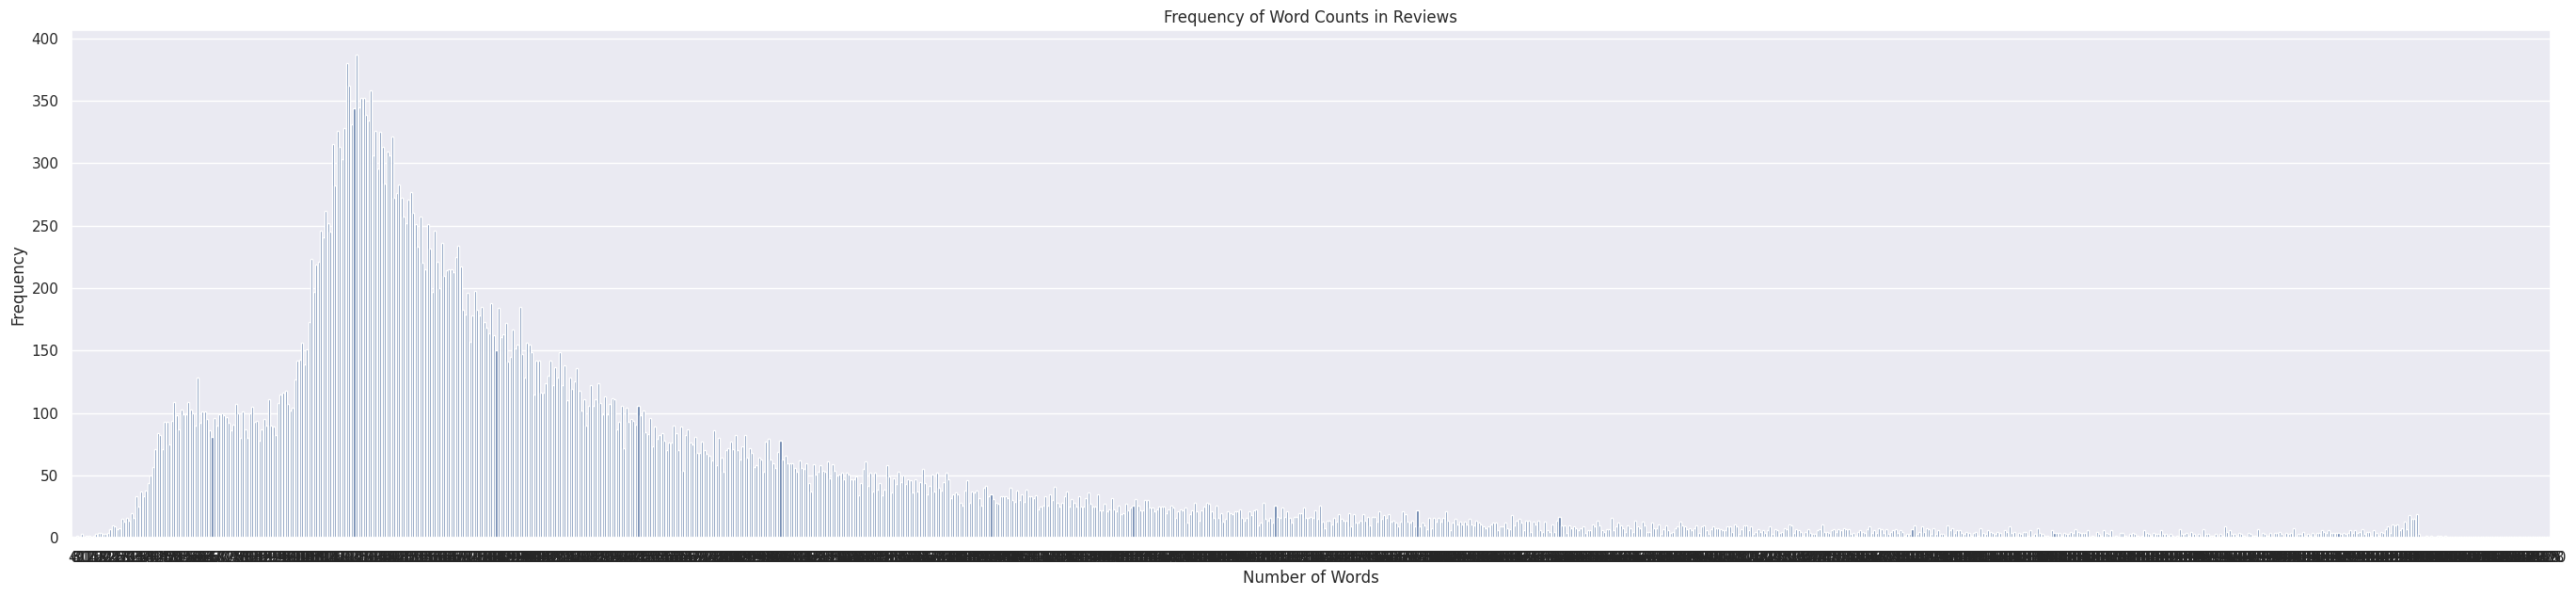

In [30]:
# Convert the frequency counter to a DataFrame for easier plotting
frequency_df = pd.DataFrame(frequency_counter.items(), columns=['word_count', 'frequency'])

# Plot the count plot
plt.figure(figsize=(34, 7))
sns.barplot(x='word_count', y='frequency', data=frequency_df)
plt.title('Frequency of Word Counts in Reviews')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

In [31]:
# split data into training data and test data
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

In [32]:
print(train_data.shape)
print(test_data.shape)

(40000, 2)
(10000, 2)


In [33]:
# Tokenize text data
tokenizer = Tokenizer(num_words=5000)  # this will take only most frequent 5000 words
tokenizer.fit_on_texts(train_data["review"])  # fit on train data
X_train = pad_sequences(tokenizer.texts_to_sequences(train_data["review"]), maxlen=200)  # transform on train data
X_test = pad_sequences(tokenizer.texts_to_sequences(test_data["review"]), maxlen=200)    # transform on test data

In [34]:
print(X_train)
print(X_test)

[[1935    1 1200 ...  205  351 3856]
 [   3 1651  595 ...   89  103    9]
 [   0    0    0 ...    2  710   62]
 ...
 [   0    0    0 ... 1641    2  603]
 [   0    0    0 ...  245  103  125]
 [   0    0    0 ...   70   73 2062]]
[[   0    0    0 ...  995  719  155]
 [  12  162   59 ...  380    7    7]
 [   0    0    0 ...   50 1088   96]
 ...
 [   0    0    0 ...  125  200 3241]
 [   0    0    0 ... 1066    1 2305]
 [   0    0    0 ...    1  332   27]]


In [35]:
Y_train = train_data["sentiment"]
Y_test = test_data["sentiment"]

In [36]:
print(Y_train)
print(Y_test)

39087    0
30893    0
45278    1
16398    0
13653    0
        ..
11284    1
44732    1
38158    0
860      1
15795    1
Name: sentiment, Length: 40000, dtype: int64
33553    1
9427     1
199      0
12447    1
39489    0
        ..
28567    0
25079    1
18707    1
15200    0
5857     1
Name: sentiment, Length: 10000, dtype: int64


## **Model-Architecture & Model Evaluation**

In [55]:
# build the model

model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=200))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation="sigmoid"))

In [56]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 200, 128)          640000    
                                                                 
 lstm_4 (LSTM)               (None, 128)               131584    
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 771713 (2.94 MB)
Trainable params: 771713 (2.94 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [57]:
# compile the model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [58]:
history = model.fit(X_train, Y_train, epochs=5, batch_size=64, validation_split=0.2)

Epoch 1/5
500/500 [==============================] - 75s 147ms/step - loss: 0.3897 - accuracy: 0.8229 - val_loss: 0.3704 - val_accuracy: 0.8429
Epoch 2/5
500/500 [==============================] - 73s 146ms/step - loss: 0.2733 - accuracy: 0.8922 - val_loss: 0.3080 - val_accuracy: 0.8777
Epoch 3/5
500/500 [==============================] - 74s 148ms/step - loss: 0.2198 - accuracy: 0.9133 - val_loss: 0.3395 - val_accuracy: 0.8656
Epoch 4/5
500/500 [==============================] - 74s 147ms/step - loss: 0.1878 - accuracy: 0.9268 - val_loss: 0.3230 - val_accuracy: 0.8712
Epoch 5/5
500/500 [==============================] - 74s 147ms/step - loss: 0.1754 - accuracy: 0.9320 - val_loss: 0.3650 - val_accuracy: 0.8684


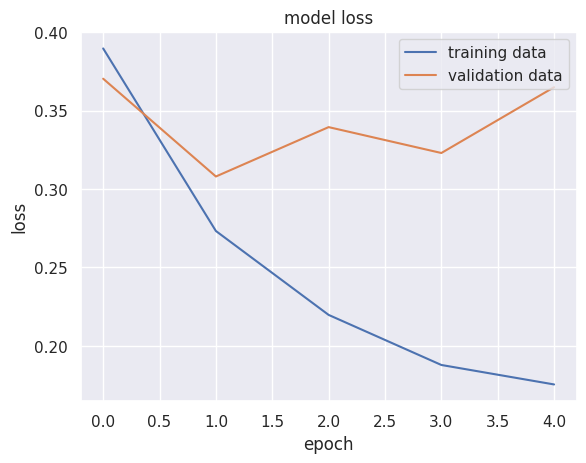

In [64]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend(['training data', 'validation data'], loc = 'upper right')

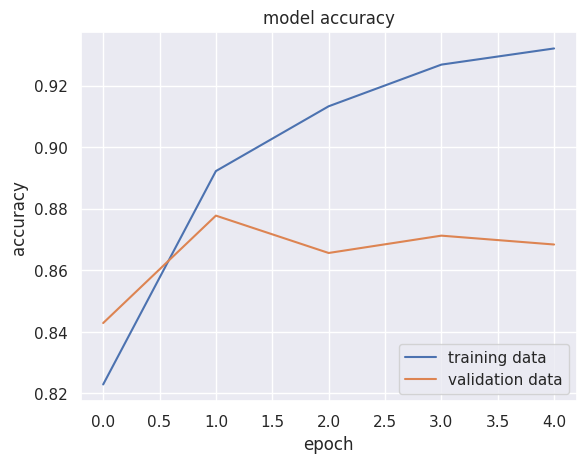

In [65]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.legend(['training data', 'validation data'], loc = 'lower right')

In [66]:
# testing on test data ...
loss, accuracy = model.evaluate(X_test, Y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

313/313 [==============================] - 10s 32ms/step - loss: 0.3507 - accuracy: 0.8715
Test Loss: 0.3507213890552521
Test Accuracy: 0.8715000152587891


# **Accuracy Score**

In [67]:
# make predictions ...
y_log = model.predict(X_test)

# the predicted values in not in 0 1 form , because we use sigmoid function it returns a probability, so we have to convert it into 0 1 using some threshold value ..
y_pred = np.where(y_log>0.5,1,0)

313/313 [==============================] - 10s 32ms/step


In [68]:
from sklearn.metrics import accuracy_score
accuracy_score(Y_test,y_pred)

0.8715

## **Building a Predictive System**

In [69]:
def predict_sentiment(review):
  # tokenize and pad the review
  sequence = tokenizer.texts_to_sequences([review])
  padded_sequence = pad_sequences(sequence, maxlen=200)
  prediction = model.predict(padded_sequence)
  sentiment = "positive" if prediction[0][0] > 0.5 else "negative"
  return sentiment

In [70]:
# example usage
new_review = "This movie was fantastic. I loved it."
sentiment = predict_sentiment(new_review)
print(f"The sentiment of the review is: {sentiment}")

1/1 [==============================] - 0s 44ms/step
The sentiment of the review is: positive


In [71]:
# example usage
new_review = "This movie was not that good"
sentiment = predict_sentiment(new_review)
print(f"The sentiment of the review is: {sentiment}")

1/1 [==============================] - 0s 44ms/step
The sentiment of the review is: negative


In [72]:
# example usage
new_review = "This movie was ok but not that good."
sentiment = predict_sentiment(new_review)
print(f"The sentiment of the review is: {sentiment}")

1/1 [==============================] - 0s 45ms/step
The sentiment of the review is: negative


In [75]:
# example usage
new_review = "This movie sound was not good, but the way of represent the story was better,but cast not that good, so overall it is good."
sentiment = predict_sentiment(new_review)
print(f"The sentiment of the review is: {sentiment}")

1/1 [==============================] - 0s 44ms/step
The sentiment of the review is: positive
